# TSNN examples

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils

In [2]:
z = generators.Generator(1000, 100, 10)

In [3]:
%%time
X, y = z.generate_dataset()

CPU times: user 536 ms, sys: 39.4 ms, total: 576 ms
Wall time: 81.4 ms


In [4]:
X.shape, y.shape

(torch.Size([1000, 100, 10]), torch.Size([1000, 100]))

In [5]:
train, test = utils.np_to_torch(X, y)

700 300


### Simple benchmarks

In [7]:
X, y = utils.torch_to_np(train)

In [9]:
# lasso benchmark
lasso = ml_benchmarks.LassoBenchmark()
lasso.fit(train)

In [10]:
lasso.score(train)

np.float64(0.048792118395638046)

In [12]:
np.corrcoef(y, z.y_pred_optimal[train.dataset.indices].flatten())

array([[1.        , 0.04825836],
       [0.04825836, 1.        ]])

In [13]:
# any custom benchmark
from sklearn.linear_model import LinearRegression
lr = ml_benchmarks.CustomBenchmark(LinearRegression())
lr.fit(train)

In [14]:
comp = benchmark_comparison.Comparator(models=[lasso, lr], model_names=['lasso', 'lr'])

In [15]:
train.dataset.dataset.y.flatten()

tensor([-0.8833,  0.3393,  0.6426,  ..., -2.2936,  1.4217, -0.4687])

In [16]:
comp.correl(train, z.y_pred_optimal[train.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr
y_true,1.000000,0.048258,0.048792,0.049184
y_optimal,0.048258,1.000000,0.986227,0.981179
lasso,0.048792,0.986227,1.000000,0.992032
lr,0.049184,0.981179,0.992032,1.000000


In [17]:
comp.correl(test, z.y_pred_optimal[train.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr
y_true,1.000000,0.006560,0.047635,0.048061
y_optimal,0.006560,1.000000,0.003623,0.003117
lasso,0.047635,0.003623,1.000000,0.992038
lr,0.048061,0.003117,0.992038,1.000000


### Torch benchmarks

In [18]:
train.batch_size, test.batch_size

(64, 64)

In [19]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_ts, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_ts*n_f, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, n_ts),
        )

    def forward(self, x):
        x = self.flatten(x)
        pred = self.linear_relu_stack(x)
        return pred

In [20]:
m = NeuralNetwork(n_ts=100, n_f=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [21]:
model_torch.fit(train, test, epochs=20)

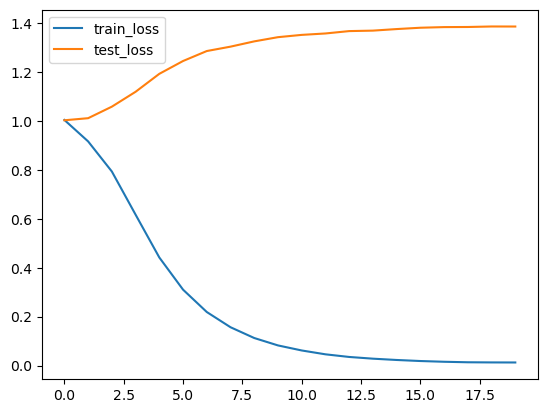

In [22]:
pd.concat([pd.Series(model_torch.train_loss).rename('train_loss'), pd.Series(model_torch.test_loss).rename('test_loss')], axis=1).plot();

In [23]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_torch], model_names=['lasso', 'lr', 'nn'])

In [24]:
comp.correl(train, z.y_pred_optimal[train.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr,nn
y_true,1.000000,0.048258,0.048792,0.049184,0.994971
y_optimal,0.048258,1.000000,0.986227,0.981179,0.048683
lasso,0.048792,0.986227,1.000000,0.992032,0.049276
lr,0.049184,0.981179,0.992032,1.000000,0.049660
nn,0.994971,0.048683,0.049276,0.049660,1.000000


In [25]:
comp.correl(test, z.y_pred_optimal[test.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr,nn
y_true,1.000000,0.049249,0.047635,0.048061,0.017445
y_optimal,0.049249,1.000000,0.985925,0.981002,0.032595
lasso,0.047635,0.985925,1.000000,0.992038,0.033638
lr,0.048061,0.981002,0.992038,1.000000,0.035618
nn,0.017445,0.032595,0.033638,0.035618,1.000000
